<a href="https://colab.research.google.com/github/Shreya-singh01/HealthGuard/blob/main/Anomaly_Detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd

# API endpoint
url = "https://datasets-server.huggingface.co/first-rows?dataset=infinite-dataset-hub%2FHealthVitalSigns&config=default&split=train"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()

    rows = data.get('rows', [])
    records = [row['row'] for row in rows]
    df = pd.DataFrame(records)

    df.to_csv("HealthVitalSigns.csv", index=False)
    print("Dataset downloaded and saved as 'HealthVitalSigns.csv'.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

Dataset downloaded and saved as 'HealthVitalSigns.csv'.


In [2]:
import pandas as pd

# Load the dataset
file_path = '/content/HealthVitalSigns.csv'
df = pd.read_csv(file_path)

df.head()

print("Missing Values:\n", df.isnull().sum())

df.info()

df.describe()


Missing Values:
 idx                0
Timestamp          0
HeartRate          0
BloodPressure      0
RespirationRate    0
Temperature        0
Label              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   idx              100 non-null    int64  
 1   Timestamp        100 non-null    object 
 2   HeartRate        100 non-null    int64  
 3   BloodPressure    100 non-null    object 
 4   RespirationRate  100 non-null    int64  
 5   Temperature      100 non-null    float64
 6   Label            100 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 5.6+ KB


,idx,HeartRate,RespirationRate,Temperature
count,100.000000,100.000000,100.000000,100.000000
mean,49.500000,88.410000,19.380000,99.771000
std,29.011492,29.465301,8.255736,2.900759
min,0.000000,50.000000,11.000000,95.800000
25%,24.750000,68.000000,15.000000,98.200000
50%,49.500000,75.000000,17.000000,98.600000
75%,74.250000,110.000000,20.250000,100.125000
max,99.000000,175.000000,52.000000,110.500000


In [3]:


from sklearn.preprocessing import MinMaxScaler

for column in df.select_dtypes(include=['number']).columns:
    df[column] = df[column].fillna(df[column].median())
numeric_features = df.select_dtypes(include=['int64', 'float64'])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(numeric_features)
X_scaled = pd.DataFrame(X_scaled, columns=numeric_features.columns)

In [4]:
# Convert the 'Label' column to numeric before calculating the sum
true_anomaly_ratio = pd.to_numeric(df['Label'], errors='coerce').sum() / len(df)

In [5]:
from sklearn.ensemble import IsolationForest

# Train the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.5, random_state=42)
model.fit(X_scaled)

df['anomaly'] = model.predict(X_scaled)

df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

print(df['anomaly'].value_counts())

anomaly
0    50
1    50
Name: count, dtype: int64


In [6]:
# from sklearn.metrics import classification_report, confusion_matrix

# # Assuming you have a labeled dataset (optional for unsupervised models)
# # Here we simulate labels just for demonstration (0 for normal, 1 for anomalies)
# y_true = df['anomaly']
# y_pred = model.predict(X_scaled)
# y_pred = pd.Series(y_pred).map({1: 0, -1: 1})

# # Evaluation metrics
# print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
# print("Classification Report:\n", classification_report(y_true, y_pred))

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = df['anomaly']
y_pred = model.predict(X_scaled)
y_pred = pd.Series(y_pred).map({1: 0, -1: 1})

y_true_no_nan = y_true.dropna()
y_pred_no_nan = y_pred[y_true_no_nan.index]

print("Confusion Matrix:\n", confusion_matrix(y_true_no_nan, y_pred_no_nan))
print("Classification Report:\n", classification_report(y_true_no_nan, y_pred_no_nan))

Confusion Matrix:
 [[50  0]
 [ 0 50]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



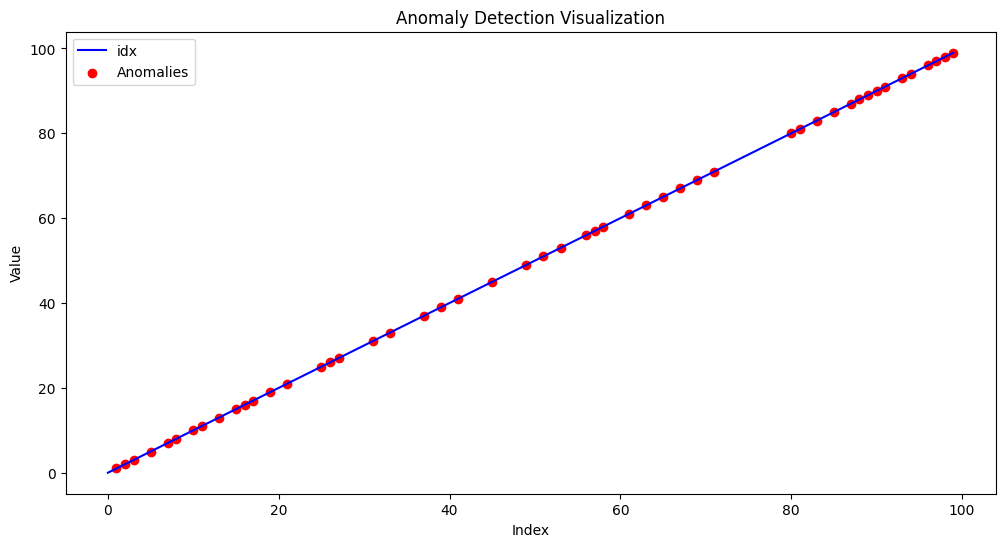

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[numeric_features.columns[0]], label=numeric_features.columns[0], color='blue')  # Example feature
anomalies = df[df['anomaly'] == 1]
plt.scatter(anomalies.index, anomalies[numeric_features.columns[0]], color='red', label='Anomalies')
plt.title("Anomaly Detection Visualization")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

In [9]:
anomalies = df[df['anomaly'] == 1]
anomalies.to_csv('/content/detected_anomalies.csv', index=False)

df.to_csv('/content/health_data_with_anomalies.csv', index=False)


In [10]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_labels = lof.fit_predict(X_scaled)

df['lof_anomaly'] = pd.Series(lof_labels).map({1: 0, -1: 1})

print(df['lof_anomaly'].value_counts())

lof_anomaly
0    95
1     5
Name: count, dtype: int64


In [11]:
import joblib

# Save the Isolation Forest model
model_filename = '/content/isolation_forest_model.pkl'
joblib.dump(model, model_filename)
scaler_filename = '/content/scaler.pkl'
joblib.dump(scaler, scaler_filename)

['/content/scaler.pkl']

Number of anomalies detected: 50
Anomaly samples:
    idx            Timestamp  HeartRate BloodPressure  RespirationRate  \
1    1  2023-01-01T12:05:00         88        135/85               18   
2    2  2023-01-01T12:10:00        115       160/100               20   
3    3  2023-01-01T12:15:00         68        110/70               15   
5    5  2023-01-01T12:25:00        110        145/92               22   
7    7  2023-01-01T12:35:00         78        128/84               18   

   Temperature    Label  anomaly  lof_anomaly  
1         99.1   Normal        1            0  
2        101.2  Anomaly        1            0  
3         98.4   Normal        1            0  
5        100.5  Anomaly        1            0  
7         98.9   Normal        1            0  


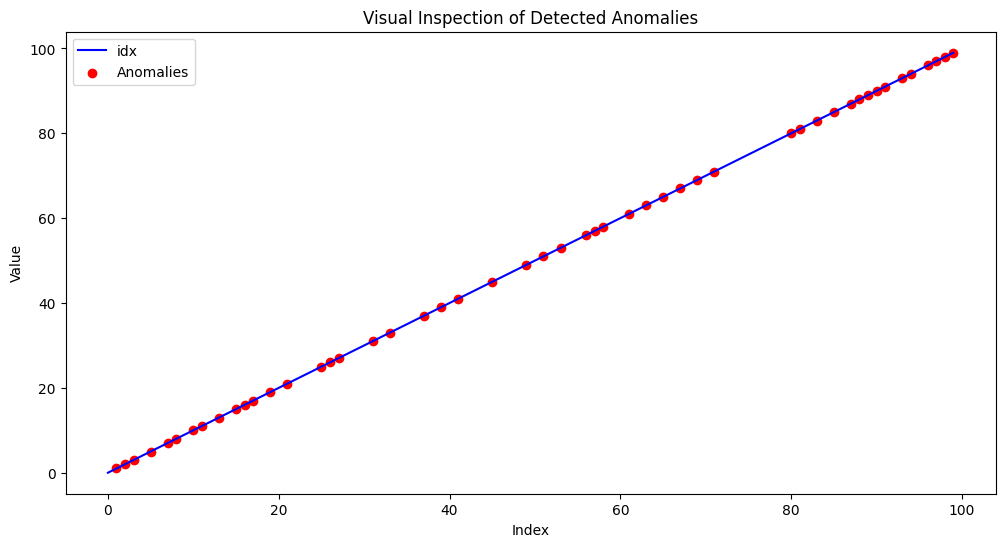

In [12]:
anomalies = df[df['anomaly'] == 1]
print("Number of anomalies detected:", len(anomalies))
print("Anomaly samples:\n", anomalies.head())

# Visualize anomalies in a scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[numeric_features.columns[0]], label=numeric_features.columns[0], color='blue')
plt.scatter(anomalies.index, anomalies[numeric_features.columns[0]], color='red', label='Anomalies')
plt.title("Visual Inspection of Detected Anomalies")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Ground truth labels
y_true = df['Label'].map({'Normal': 0, 'Anomaly': 1})   # Replace 'anomaly_label' with your actual label column

# Model predictions
y_pred = df['anomaly']  # Output from Isolation Forest

# Evaluation Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the results
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))
print("Classification Report:\n", classification_report(y_true, y_pred))


Confusion Matrix:
 [[45 18]
 [ 5 32]]
Accuracy: 0.77
Precision: 0.64
Recall: 0.8649
F1 Score: 0.7356
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.80        63
           1       0.64      0.86      0.74        37

    accuracy                           0.77       100
   macro avg       0.77      0.79      0.77       100
weighted avg       0.80      0.77      0.77       100

